# Assignment 2

By Gal Noy

### Test Plan
In this assignment, I will test my implementation of the Flajolet-Martin ($\alpha$, $\beta$, and final estimators) 
and Count-Min Sketch algorithms. These algorithms will be examined with different sketch sizes.

The stream used for testing contains 100,000 elements, with 10,000 of them being unique.

For each estimator, the following steps will be performed:
1. Run each sketch size 25 times to ensure statistical consistency.
2. For every sketch size, compute and visualize:
   - Accuracy
   - Bias
   - Normalized variance
3. Determine the relative error (with $\epsilon$) that ensures a 95% success rate ($\delta = 0.05$).
4. Validate and illustrate the unbiasedness of the estimators.

## Initialization


In [500]:
import numpy as np

SEED = 42
NUM_ELEMENTS = 100000
NUM_UNIQUE = 10000
NUM_RUNS = 25

# Set the seed for reproducibility
np.random.seed(SEED)
stream = np.random.randint(0, NUM_UNIQUE, NUM_ELEMENTS)

print(f"Stream length: {len(stream)}")
print(f"Number of unique elements: {len(np.unique(stream))}")
print(f"First 10 elements of the stream: {stream[:10]}")

Stream length: 100000
Number of unique elements: 10000
First 10 elements of the stream: [7270  860 5390 5191 5734 6265  466 4426 5578 8322]


### Hashing

Below is a hash function implementation used to process the stream and a visualization of its uniformity.

The hash function is defined as:

$$h(x) = ((a \cdot x^2 + b) \mod p) \mod m$$

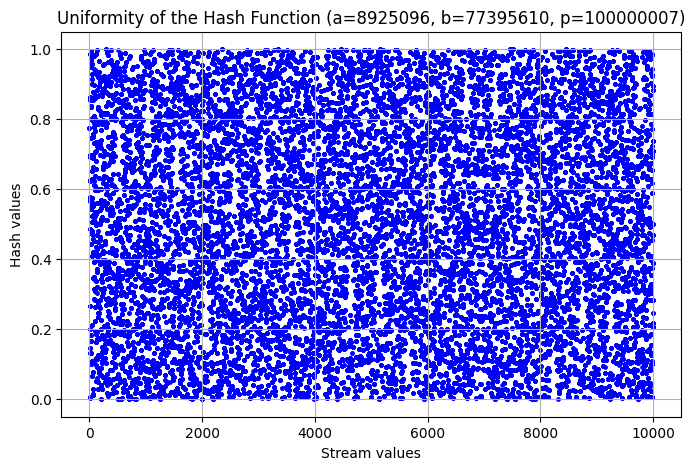

In [501]:
import matplotlib.pyplot as plt

# Prime number for the hash function, P > NUM_UNIQUE^2
P = NUM_UNIQUE**2 + 7

def hash_stream(stream: np.ndarray, a: int, b: int, m: int = P, normalize: bool = True, p: int = P) -> np.ndarray:
    """
    Hash the stream using the hash function (a * stream^2 + b) % p % m
    :param stream: The stream to hash
    :param a: The first coefficient of the hash function
    :param b: The second coefficient of the hash function
    :param m: The range of the hash function
    :param normalize: Whether to normalize the hash values to [0, 1) or not
    :param p: The prime number for the hash function
    :return: The hashed stream
    """
    return (((a * stream**2 + b) % p) % m) / (m if normalize else 1)

# Plot the uniformity of the hash function
a, b = np.random.default_rng(SEED).integers(1, P, size=2)
plt.figure(figsize=(8, 5))
plt.scatter(stream, hash_stream(stream, a, b), alpha=0.7, color='blue', s=5)
plt.title(f"Uniformity of the Hash Function (a={a}, b={b}, p={P})")
plt.xlabel("Stream values")
plt.ylabel("Hash values")
plt.grid(True)
plt.show()

## Flajolet Martin

### Flajolet Martin - $\alpha$-Version

In [502]:
def flajolet_martin(stream: np.ndarray, seed: int = SEED) -> float:
    """
    Flajolet-Martin algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param seed: seed for the random number generator
    :return: estimated number of distinct elements
    """
    a, b = np.random.default_rng(seed).integers(1, P, size=2)
    hashed_stream = hash_stream(stream, a, b)
    return 1 / np.min(hashed_stream)

In the $\alpha$-version, the sketch size is always set to 1, as there is only one estimator. If we choose a relatively large value for $\epsilon$, such as $\frac{1}{2}$, then:

$$
O\left(\frac{1}{\epsilon^2}\right) < \delta
$$

This results in $\delta > 1$, which is not acceptable since $\delta$ must be less than or equal to 1.

This means the estimator is not sufficiently accurate, as the relative error, guaranteed with 95\% success probability ($\delta = 0.05$), is $\epsilon > \sqrt{20} > 4$. In other words, the estimated count could be more than four times the actual number of unique elements.

Proof of **unbiasedness** is only possible mathematically, by proving $E\left[\frac{1}{X}\right] = n$.

In [503]:
estimates = [flajolet_martin(stream, i) for i in range(NUM_RUNS)]
mean = np.mean(estimates)
accuracy = max(0, 1 - np.abs(mean - NUM_UNIQUE) / NUM_UNIQUE)
bias = np.abs(mean - NUM_UNIQUE)
normalized_variance = np.var(estimates) / NUM_UNIQUE

print("Flajole-Martin Algorithm")
print(f"Mean estimate: {mean:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Bias: {bias:.2f}")
print(f"Normalized variance: {normalized_variance:.2f}")

Flajole-Martin Algorithm
Mean estimate: 81961.89
Accuracy: 0.00
Bias: 71961.89
Normalized variance: 4447725.19


### Flajolet Martin - $\beta$-Version

The $\beta$-version of the Flajolet-Martin algorithm improves accuracy by using $s$ estimators, each based on a different hash function.

The final cardinality estimate $N^{\beta}$ is computed as:

$$
N^{\beta} = \frac{1}{\text{mean of estimators}} - 1
$$

In [504]:
def flajolet_martin_beta(stream: np.ndarray, s: int, seed: int = SEED) -> float:
    """
    Flajolet-Martin Beta algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param s: number of FM estimators to calculate
    :param seed: seed for the random number generator
    :return: estimated number of distinct elements
    """
    hash_funcs = np.random.default_rng(seed).integers(1, P, size=(s, 2))
    estimates = np.array([hash_stream(stream, a, b) for a, b in hash_funcs])    
    Z = np.min(estimates, axis=1)
    return 1 / np.mean(Z) - 1

We learned in class that $O\left(\frac{1}{\epsilon^2 \delta}\right)$ space is needed to guarantee the accuracy of $P(|N^{\beta} - N| > \epsilon N) < \delta$.

For each sketch size, we will calculate the promised relative error for 95% success probability ($\delta = 0.05$) using the formula:

$$
\text{Relative Error} = \epsilon = \sqrt{\frac{\delta}{s}}
$$

In [505]:
delta = 0.05  # Calculate the guaranteed relative error with 95% confidence

fm_beta_results = {}

S = [2**i for i in range(8)]
for s in S:
    epsilon = np.sqrt(1 / (delta * s))
    print(f"Sketch size: {s}, Relative error: {epsilon:.2f}")
    fm_beta_results[s] = [flajolet_martin_beta(stream, s, i**3) for i in range(NUM_RUNS)]

Sketch size: 1, Relative error: 4.47
Sketch size: 2, Relative error: 3.16
Sketch size: 4, Relative error: 2.24
Sketch size: 8, Relative error: 1.58
Sketch size: 16, Relative error: 1.12
Sketch size: 32, Relative error: 0.79
Sketch size: 64, Relative error: 0.56
Sketch size: 128, Relative error: 0.40


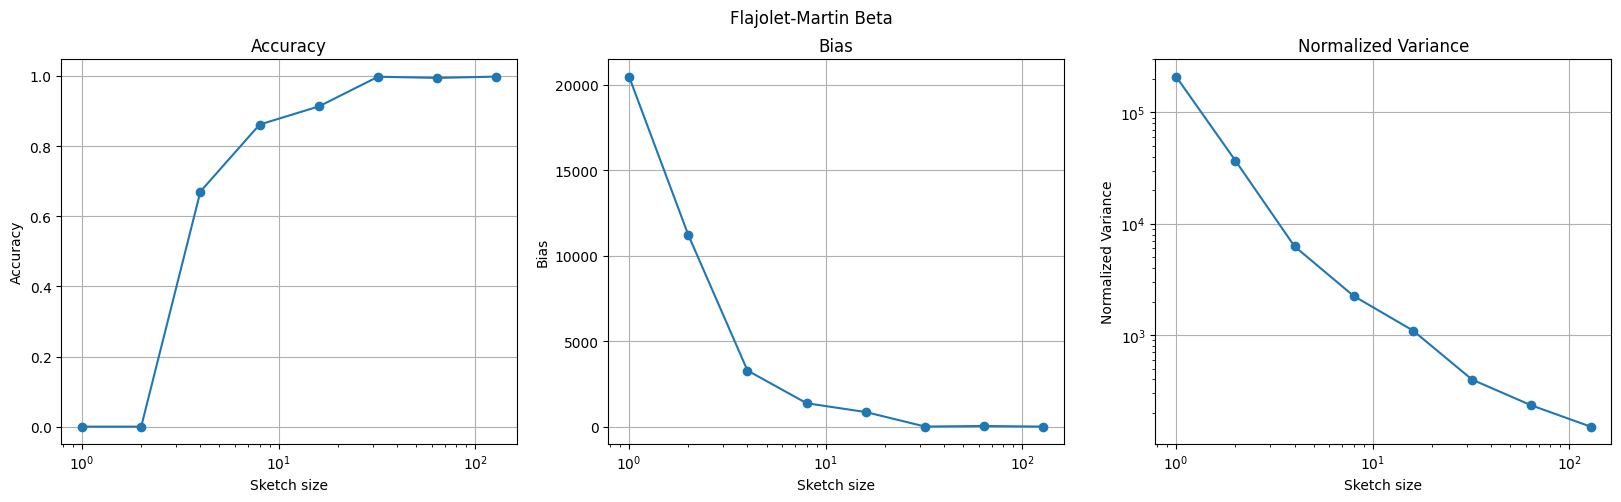

In [506]:
def calculate_fm_metrics(results: dict) -> dict:
    """
    Calculate the metrics for the Flajolet-Martin Beta algorithm.
    :param results: Dictionary with the results
    :return: Dictionary with the metrics
    """
    metrics = {}
    for sketch_size, ests in results.items():
        mean = np.mean(ests)
        accuracy = max(0, 1 - np.abs(mean - NUM_UNIQUE) / NUM_UNIQUE)
        bias = np.abs(mean - NUM_UNIQUE)
        normalized_variance = np.var(ests) / NUM_UNIQUE
        metrics[sketch_size] = {
            "accuracy": accuracy,
            "bias": bias,
            "normalized_variance": normalized_variance
        }
    return metrics

metrics = calculate_fm_metrics(fm_beta_results)

sketch_sizes = sorted(list(metrics.keys()))
    
plt.figure(figsize=(20, 5))
plt.suptitle("Flajolet-Martin Beta")

plt.subplot(1, 3, 1)
plt.plot(S, [metrics[s]["accuracy"] for s in S], marker='o')
plt.title("Accuracy")
plt.xlabel("Sketch size")
plt.xscale("log")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(S, [metrics[s]["bias"] for s in S], marker='o')
plt.title("Bias")
plt.xlabel("Sketch size")
plt.xscale("log")
plt.ylabel("Bias")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(S, [metrics[s]["normalized_variance"] for s in S], marker='o')
plt.title("Normalized Variance")
plt.xlabel("Sketch size")
plt.xscale("log")
plt.ylabel("Normalized Variance")
plt.yscale("log")
plt.grid(True)

plt.show()

As the sketch size $s$ increases, the following trends are observed:  

1. **Accuracy**: Accuracy increases as the sketch size grows, approaching $1.0$. This indicates that the estimator becomes more accurate with a larger sketch size, providing estimates closer to the true count.

2. **Bias**: The bias of the estimator decreases quickly as the sketch size increases. This shows that the estimator becomes less biased and provides results that are closer to the true value as more estimators are used.

3. **Normalized Variance**: The normalized variance follows a similar pattern to the bias, dropping sharply as the sketch size increases. For small $s$, the variance is high, but it becomes almost negligible as $s$ increases. This suggests that with a larger number of estimators, the variance decreases, leading to more consistent and reliable estimates.

This demonstrates the *unbiasedness* of the estimator: as $s$ grows, the estimator's expected value approaches the true count, leading to smaller deviations and a more reliable estimate of the cardinality.

### Flajolet Martin - Final Version

The final version of the Flajolet-Martin algorithm improves accuracy by using $t$ $\beta$-version estimators, each based on a different hash function. For each $\beta$ estimator, the cardinality estimate $N^{\beta}_i$ is computed as:

$$
N^{\beta}_i = \frac{1}{\text{mean of estimators}} - 1
$$

The final estimate $\hat{N}$ is then computed as the **median** of all these individual estimates:

$$
\hat{N} = \text{median}(N^{\beta}_1, N^{\beta}_2, \dots, N^{\beta}_t)
$$


In [507]:
def flajolet_martin_final(stream: np.ndarray, t: int, s: int, seed: int = SEED) -> float:
    """
    Flajolet-Martin Final algorithm that uses t instances of Flajolet-Martin Beta.
    :param stream: numpy array of elements
    :param t: number of Flajolet-Martin Beta instances to run
    :param s: number of FM estimators per Flajolet-Martin Beta instance
    :param seed: seed for the random number generator
    :return: median of the distinct element estimates
    """
    hash_funcs = np.random.default_rng(seed).integers(0, P, size=(t, s, 2))
    
    # t instances of Flajolet-Martin Beta, each with s estimators
    Zs = [np.min([hash_stream(stream, a, b) for a, b in hash_funcs[i]], axis=1) for i in range(t)]
    
    estimates = [1 / np.mean(Z) - 1 for Z in Zs]
    return np.median(estimates)

We learned in class that $O\left(\frac{1}{\epsilon^2} \log \frac{1}{\delta}\right)$
 space is needed to guarantee the accuracy of $P(|\hat{N} - N| > \epsilon N) < \delta$.

For each sketch size, we will calculate the promised relative error for 95\% success probability ($\delta = 0.05$) using the formula:

$$
\text{Relative Error} = \epsilon = \sqrt{\frac{\log \frac{1}{\delta}}{t \cdot s}}
$$

In [508]:
fm_final_results = {}

T = [1, 2, 3, 4, 5]
for t in T:
    print(f"Flajolet-Martin Beta instances: t={t}")
    fm_final_results[t] = {}
    for s in S:
        epsilon = np.sqrt(1 / (delta * t * s))
        print(f"FM estimators: s={s}, Relative error: {epsilon:.2f}")
        fm_final_results[t][s] = [flajolet_martin_final(stream, t, s, i**3) for i in range(NUM_RUNS)]

Flajolet-Martin Beta instances: t=1
FM estimators: s=1, Relative error: 4.47
FM estimators: s=2, Relative error: 3.16
FM estimators: s=4, Relative error: 2.24
FM estimators: s=8, Relative error: 1.58
FM estimators: s=16, Relative error: 1.12
FM estimators: s=32, Relative error: 0.79
FM estimators: s=64, Relative error: 0.56
FM estimators: s=128, Relative error: 0.40
Flajolet-Martin Beta instances: t=2
FM estimators: s=1, Relative error: 3.16
FM estimators: s=2, Relative error: 2.24
FM estimators: s=4, Relative error: 1.58
FM estimators: s=8, Relative error: 1.12
FM estimators: s=16, Relative error: 0.79
FM estimators: s=32, Relative error: 0.56
FM estimators: s=64, Relative error: 0.40
FM estimators: s=128, Relative error: 0.28
Flajolet-Martin Beta instances: t=3
FM estimators: s=1, Relative error: 2.58
FM estimators: s=2, Relative error: 1.83
FM estimators: s=4, Relative error: 1.29
FM estimators: s=8, Relative error: 0.91
FM estimators: s=16, Relative error: 0.65
FM estimators: s=32,

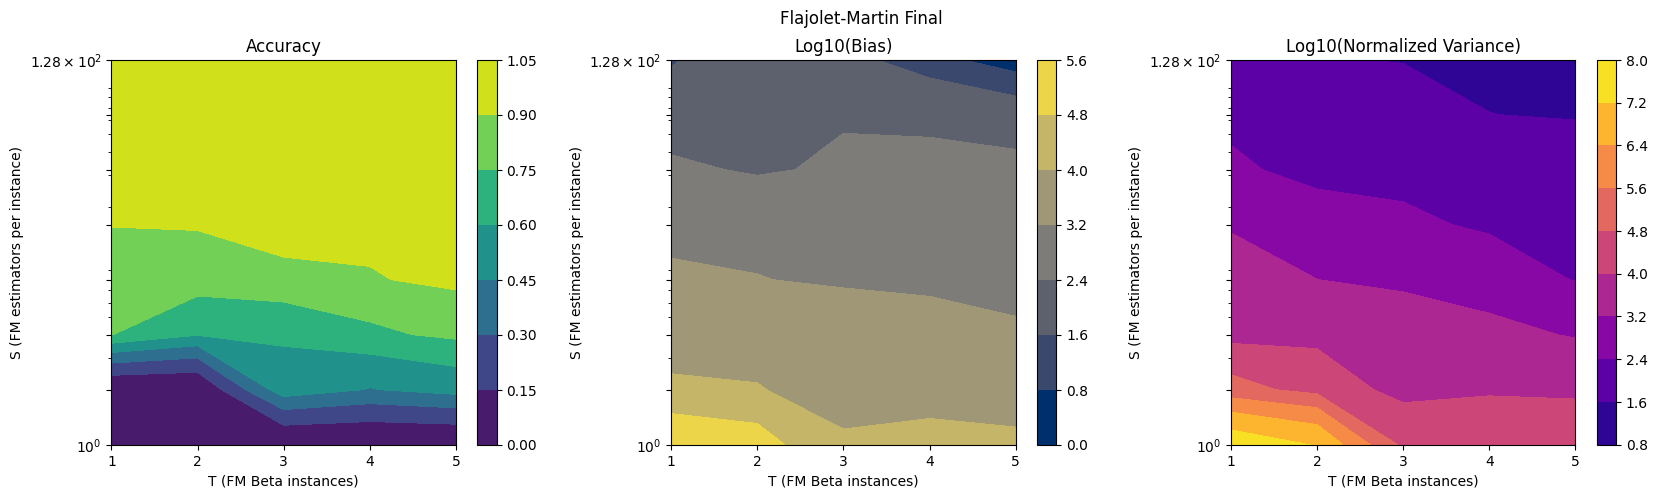

In [509]:
metrics = {t: calculate_fm_metrics(fm_final_results[t]) for t in T}

accuracy_grid = np.zeros((len(S), len(T)))
bias_grid = np.zeros((len(S), len(T)))
normalized_variance_grid = np.zeros((len(S), len(T)))

for i, t in enumerate(T):
    for j, s in enumerate(S):
        accuracy_grid[j, i] = metrics[t][s]["accuracy"]
        bias_grid[j, i] = metrics[t][s]["bias"]
        normalized_variance_grid[j, i] = metrics[t][s]["normalized_variance"]

plt.figure(figsize=(20, 5))
plt.suptitle("Flajolet-Martin Final")

plt.subplot(1, 3, 1)
contour = plt.contourf(T, S, accuracy_grid, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('T (FM Beta instances)')
plt.ylabel('S (FM estimators per instance)')
plt.yscale('log')
plt.title('Accuracy')
plt.xticks(T)
plt.yticks(S)

plt.subplot(1, 3, 2)
contour = plt.contourf(T, S, np.log10(bias_grid), cmap='cividis')
plt.colorbar(contour)
plt.xlabel('T (FM Beta instances)')
plt.ylabel('S (FM estimators per instance)')
plt.yscale('log')
plt.title('Log10(Bias)')
plt.xticks(T)
plt.yticks(S)

plt.subplot(1, 3, 3)
contour = plt.contourf(T, S, np.log10(normalized_variance_grid), cmap='plasma')
plt.colorbar(contour)
plt.xlabel('T (FM Beta instances)')
plt.ylabel('S (FM estimators per instance)')
plt.yscale('log')
plt.yscale('log')
plt.title('Log10(Normalized Variance)')
plt.xticks(T)
plt.yticks(S)

plt.subplots_adjust(wspace=0.3)
plt.show()

Similar to the $\beta$ version, the final estimator demonstrates improved trends as the sketch size increases.

Notably, increasing $T$ by 1 at each step significantly enhances the performance. As with the $\beta$ version, accuracy approaches $1.0$ as the sketch size grows, while both bias and normalized variance decrease steadily.

These trends further reinforce the *unbiasedness* and stability of the Flajolet-Martin Final estimator, with larger values of $T$ and $S$ leading to more precise and consistent estimates.

## Count-Min Sketch

The Count-Min Sketch algorithm is a probabilistic data structure used to estimate the frequency of elements in a stream with the trade-off of allowing some error. It uses a 2D array (or matrix) of counters, where each row corresponds to a hash function and each column corresponds to a hash value for an element. The algorithm uses these hash functions to map elements to specific positions in the counters, and it returns an approximate count of each element in the stream.

This implementation works as follows:

1. **Initialization**: The sketch is initialized as a 2D array of zeros with dimensions `d x w`, where `d` is the depth (number of hash functions) and `w` is the width (size of the counter array for each hash function).

2. **Hash Functions**: The algorithm generates `d` random hash functions, each producing a pair of indices. These indices are used to map each unique element in the stream to positions in the sketch.

3. **Update the Sketch**: For each element in the stream, the sketch is updated at the corresponding hash indices with the element's frequency.

4. **Estimate Frequencies**: The estimated frequency of each unique element is calculated by taking the minimum value across all rows for the corresponding column indices. This helps reduce the effect of hash collisions.

### Formula

The Count-Min Sketch estimate for the frequency of an element $x$ is given by:

$$
\hat{f}(x) = \min_{1 \leq i \leq d} \text{sketch}[i, \text{hash}_i(x)]
$$

Where:  
- $f(x)$ is the true frequency of element $x$ in the stream.  
- $\hat{f}(x)$ is the estimated frequency of $x$ produced by the Count-Min Sketch. 
- $\text{hash}_i(x)$ is the hash function for the $i$-th row, which maps $x$ to a column index.  

In [510]:
def count_min_sketch(stream: np.ndarray, d: int, w: int, seed: int = SEED) -> np.ndarray:
    """
    Count-Min Sketch algorithm for counting the frequency of elements in a stream.
    :param stream: array of elements
    :param d: depth of the sketch (number of hash functions)
    :param w: width of the sketch
    :param seed: seed for the random number generator
    :return: estimated frequency of each unique element in the stream
    """
    # Initialize the sketch
    sketch = np.zeros((d, w))
    
    # Hash each unique stream elements to d indices (one for each hash function)
    hash_funcs = np.random.default_rng(seed).integers(0, w, size=(d, 2))
    unique_elements, counts = np.unique(stream, return_counts=True)
    unique_element_to_indices = np.array([[int(val) for val in hash_stream(unique_elements, a, b, w, normalize=False)] for a, b in hash_funcs]).T
    assert unique_element_to_indices.shape == (len(unique_elements), d), f"Unique element to indices shape: {unique_element_to_indices.shape}"
    
    # According to each unique element frequency (count), update the sketch at the hashed indices
    np.add.at(sketch, (np.arange(d)[:, None], unique_element_to_indices.T), counts)

    # Calculate estimated frequencies for each unique element in the stream
    freqs = np.array([np.min([sketch[j, unique_element_to_indices[i, j]] for j in range(d)]) for i in range(len(unique_elements))])
    
    return freqs

We learned in class that a space of $O\left( \frac{\log F_1 \cdot \log \frac{1}{\delta}}{\epsilon} \right)$ is needed to guarantee the accuracy of the following inequality:

$$
P\left( f_{x} \leq \hat{f}_{x} \leq f_{x} + \epsilon F_1 \right) \geq 1 - \delta
$$

For each sketch size $s = d \cdot w$, we will calculate the promised relative error for 95\% success probability ($\delta = 0.05$) using the formula:

$$
\text{Relative Error} = \epsilon = \frac{\log F_1 \cdot \log \frac{1}{\delta}}{d \cdot w}
$$

*Reminder: $F_1$ is the first norm, i.e., $F_1 = \sum_x |f_x|$

In [514]:
count_min_results = {}

D = [1, 2, 3, 4]
W = [1000, 2500, 5000, 7500, 10000, 25000, 50000, 75000]
for d in D:
    print(f"Depth: {d}")
    count_min_results[d] = {}
    for w in W:
        epsilon = np.sqrt(np.log(NUM_ELEMENTS) * np.log(1 / delta) / (d * w))  # F1 = NUM_ELEMENTS
        print(f"Width: {w}, Relative error: {epsilon:.2f}")
        count_min_results[d][w] = [count_min_sketch(stream, d, w, i) for i in range(NUM_RUNS)]

Depth: 1
Width: 1000, Relative error: 0.19
Width: 2500, Relative error: 0.12
Width: 5000, Relative error: 0.08
Width: 7500, Relative error: 0.07
Width: 10000, Relative error: 0.06
Width: 25000, Relative error: 0.04
Width: 50000, Relative error: 0.03
Width: 75000, Relative error: 0.02
Depth: 2
Width: 1000, Relative error: 0.13
Width: 2500, Relative error: 0.08
Width: 5000, Relative error: 0.06
Width: 7500, Relative error: 0.05
Width: 10000, Relative error: 0.04
Width: 25000, Relative error: 0.03
Width: 50000, Relative error: 0.02
Width: 75000, Relative error: 0.02
Depth: 3
Width: 1000, Relative error: 0.11
Width: 2500, Relative error: 0.07
Width: 5000, Relative error: 0.05
Width: 7500, Relative error: 0.04
Width: 10000, Relative error: 0.03
Width: 25000, Relative error: 0.02
Width: 50000, Relative error: 0.02
Width: 75000, Relative error: 0.01
Depth: 4
Width: 1000, Relative error: 0.09
Width: 2500, Relative error: 0.06
Width: 5000, Relative error: 0.04
Width: 7500, Relative error: 0.03


In [515]:
unique_elements, counts = np.unique(stream, return_counts=True)

# Calculate the metrics for the Count-Min Sketch algorithm
metrics = {}
for d, results in count_min_results.items():
    metrics[d] = {}
    for w, freqs_list in results.items():
        # Accuracy (with Mean Absolute Error)
        errors = [np.sum(np.abs(freqs - counts)) for freqs in freqs_list]
        mean_absolute_error = np.mean(errors)
        accuracy = max(0, 1 - mean_absolute_error / len(stream))
        
        # Average bias, average normalized-variance
        biases = []
        variances = []
        for i, _ in enumerate(unique_elements):
            estimates = np.array([freqs[i] for freqs in freqs_list])
            true_count = counts[i]
            bias = np.mean(estimates) - true_count
            variance = np.var(estimates) / true_count
            biases.append(bias)
            variances.append(variance)
        
        avg_bias = np.mean(np.abs(biases))
        avg_normalized_variance = np.mean(variances)
        
        metrics[d][w] = {
            "accuracy": accuracy,
            "bias": avg_bias,
            "normalized_variance": avg_normalized_variance
        }

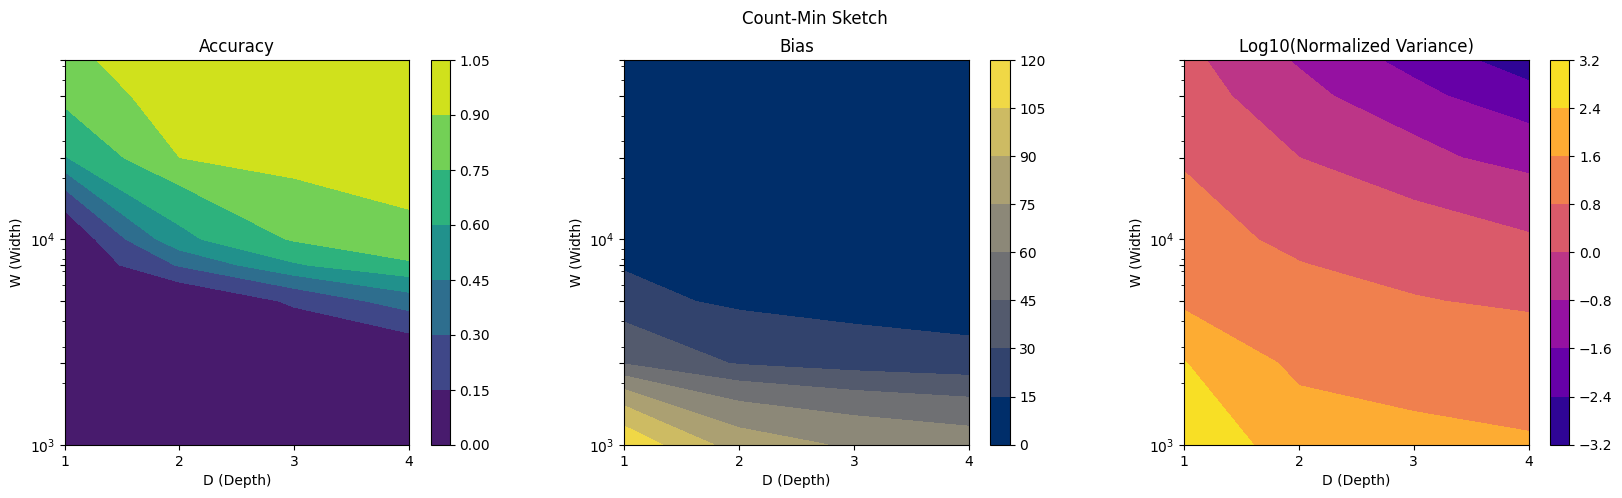

In [516]:
accuracy_grid = np.zeros((len(S), len(T)))
bias_grid = np.zeros((len(S), len(T)))
normalized_variance_grid = np.zeros((len(S), len(T)))

accuracy_grid = np.zeros((len(W), len(D)))
bias_grid = np.zeros((len(W), len(D)))
normalized_variance_grid = np.zeros((len(W), len(D)))

for i, d in enumerate(D):
    for j, w in enumerate(W):
        accuracy_grid[j, i] = metrics[d][w]["accuracy"]
        bias_grid[j, i] = metrics[d][w]["bias"]
        normalized_variance_grid[j, i] = metrics[d][w]["normalized_variance"]

plt.figure(figsize=(20, 5))
plt.suptitle("Count-Min Sketch")

plt.subplot(1, 3, 1)
contour = plt.contourf(D, W, accuracy_grid, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('D (Depth)')
plt.ylabel('W (Width)')
plt.yscale('log')
plt.title('Accuracy')
plt.xticks(D)
plt.yticks(W)

plt.subplot(1, 3, 2)
contour = plt.contourf(D, W, bias_grid, cmap='cividis')
plt.colorbar(contour)
plt.xlabel('D (Depth)')
plt.ylabel('W (Width)')
plt.yscale('log')
plt.title('Bias')
plt.xticks(D)
plt.yticks(W)

plt.subplot(1, 3, 3)
contour = plt.contourf(D, W, np.log10(normalized_variance_grid), cmap='plasma')
plt.colorbar(contour)
plt.xlabel('D (Depth)')
plt.ylabel('W (Width)')
plt.yscale('log')
plt.title('Log10(Normalized Variance)')
plt.xticks(D)
plt.yticks(W)

plt.subplots_adjust(wspace=0.3)
plt.show()

As the sketch size $s$ (determined by depth $d$ and width $w$) increases, the following trends are observed:  

1. **Accuracy**: Accuracy increases sharply with both depth and width. Increasing width $w$ has the most significant impact, as it reduces collisions and brings accuracy closer to $1.0$. While depth $d$ contributes to accuracy improvement, the effect is less pronounced compared to width.
Notably, we observed a significant increase in accuracy only when the width **passed the unique number** (10k in our case). Below this threshold, accuracy remained around 0.15.

2. **Bias**: Bias decreases as both depth and width increase. Increasing depth $d$ helps reduce bias by refining the estimates, while increasing width $w$ accelerates this reduction by minimizing hash collisions. Together, they make the estimator's results approach the true count more quickly.

3. **Normalized Variance**: Variance drops significantly as both depth and width increase. Increasing width $w$ has the most rapid effect on variance, leading to a more stable and reliable estimator. Depth $d$ also contributes to variance reduction, though its effect is slower and secondary to the impact of width. 

In summary, as sketch size increases, accuracy improves, bias diminishes, and variance reduces, demonstrating the *unbiasedness* of the Count-Min sketch estimator.